In [1]:
# jupyter magic reload
%load_ext autoreload
%autoreload 2

from utils import *
from crosscoder import CrossCoder
from transformer_lens import HookedTransformer
from transformers import AutoModelForCausalLM, AutoTokenizer
torch.set_grad_enabled(False);

cross_coder = CrossCoder.load('version_13', 4)
'''
checkpoint = torch.load("datasets/none_hooked.pt", map_location="cuda")
base_model = HookedTransformer(checkpoint["config"])
base_model.load_state_dict(checkpoint["state_dict"])
'''
base_model = HookedTransformer.from_pretrained("google/gemma-2-2b")
base_model.cuda()

checkpoint = torch.load("datasets/half_hooked.pt", map_location="cuda")
tuned_model = HookedTransformer(checkpoint["config"])
tuned_model.load_state_dict(checkpoint["state_dict"]);

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
{'batch_size': 4096,
 'beta1': 0.9,
 'beta2': 0.999,
 'buffer_mult': 128,
 'd_in': 2304,
 'dec_init_norm': 0.08,
 'device': 'cuda:0',
 'dict_size': 16384,
 'enc_dtype': 'fp32',
 'hook_point': 'blocks.22.hook_resid_pre',
 'l1_coeff': 2,
 'log_every': 200,
 'lr': 5e-05,
 'model_batch_size': 4,
 'model_name': 'gemma-2-2b',
 'num_tokens': 60000000,
 'save_every': 3000,
 'seed': 49,
 'seq_len': 1024,
 'site': 'resid_pre',
 'wandb_entity': 'santiago-aranguri-reg-new-york-university',
 'wandb_project': 'a'}


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loaded pretrained model google/gemma-2-2b into HookedTransformer
Moving model to device:  cuda


In [2]:
show = True
norms = cross_coder.W_dec.norm(dim=-1)
norms.shape
relative_norms = norms[:, 1] / norms.sum(dim=-1)
relative_norms.shape

fig = px.histogram(
    relative_norms.detach().cpu().numpy(), 
    title="Gemma 2 2B Base vs IT Model Diff",
    labels={"value": "Relative decoder norm strength"},
    nbins=200,
)

fig.update_layout(showlegend=False)
fig.update_yaxes(title_text="Number of Latents")

# Update x-axis ticks
fig.update_xaxes(
    tickvals=[0, 0.25, 0.5, 0.75, 1.0],
    ticktext=['0', '0.25', '0.5', '0.75', '1.0']
)

if show: fig.show()

shared_latent_mask = relative_norms > -.95#(relative_norms < 0.7) & (relative_norms > 0.3)
shared_latent_mask.shape
# Cosine similarity of recoder vectors between models
cosine_sims = (cross_coder.W_dec[:, 0, :] * cross_coder.W_dec[:, 1, :]).sum(dim=-1) / (cross_coder.W_dec[:, 0, :].norm(dim=-1) * cross_coder.W_dec[:, 1, :].norm(dim=-1))
cosine_sims.shape

import plotly.express as px
import torch

fig = px.histogram(
    cosine_sims[shared_latent_mask].to(torch.float32).detach().cpu().numpy(), 
    #title="Cosine similarity of decoder vectors between models",
    log_y=True,  # Sets the y-axis to log scale
    range_x=[-1, 1],  # Sets the x-axis range from -1 to 1
    nbins=100,  # Adjust this value to change the number of bins
    labels={"value": "Cosine similarity of decoder vectors between models"}
)

fig.update_layout(showlegend=False)
fig.update_yaxes(title_text="Number of Latents (log scale)")

if show: fig.show()
#

In [4]:
test_feature_idx = torch.cat((torch.argwhere(relative_norms > .7).flatten(), torch.argwhere(relative_norms <1-.7).flatten()))

In [5]:
test_feature_idx

tensor([   67,   240,   860,  2263,  2886,  2928,  3840,  4650,  4783,  5166,
         5339,  5449,  6307,  6435,  6595,  6708,  6793,  6803,  7039,  7708,
         7813,  8299,  8465,  8929,  9061,  9738,  9852,  9997, 10244, 10559,
        10628, 11074, 11145, 11251, 11474, 12047, 12476, 12680, 13088, 13313,
        14090, 14335, 14626, 14786, 15633, 16186,   164,   646,  1411,  1419,
         1434,  1928,  2116,  2250,  2300,  2357,  2824,  3141,  3401,  3668,
         3815,  4007,  4240,  5501,  5667,  6623,  6669,  6752,  6810,  7696,
         7837,  9334,  9879, 12006, 12087, 13061, 13145, 13407, 13705, 13745,
        13937, 15929, 16105], device='cuda:0')

In [5]:
base_estimated_scaling_factor = 0.2835
chat_estimated_scaling_factor = 0.2835#0.2533

import copy
folded_cross_coder = copy.deepcopy(cross_coder)

def fold_activation_scaling_factor(cross_coder, base_scaling_factor, chat_scaling_factor):
    cross_coder.W_enc.data[0, :, :] = cross_coder.W_enc.data[0, :, :] * base_scaling_factor
    cross_coder.W_enc.data[1, :, :] = cross_coder.W_enc.data[1, :, :] * chat_scaling_factor

    # cross_coder.W_dec.data[:, 0, :] = cross_coder.W_dec.data[:, 0, :] / base_scaling_factor
    # cross_coder.W_dec.data[:, 1, :] = cross_coder.W_dec.data[:, 1, :] / chat_scaling_factor

    # cross_coder.b_dec.data[0, :] = cross_coder.b_dec.data[0, :] / base_scaling_factor
    # cross_coder.b_dec.data[1, :] = cross_coder.b_dec.data[1, :] / chat_scaling_factor
    return cross_coder

folded_cross_coder = fold_activation_scaling_factor(folded_cross_coder, base_estimated_scaling_factor, chat_estimated_scaling_factor)

from sae_vis.model_fns import CrossCoderConfig, CrossCoder

encoder_cfg = CrossCoderConfig(d_in=base_model.cfg.d_model, d_hidden=cross_coder.cfg["dict_size"], apply_b_dec_to_input=False)
sae_vis_cross_coder = CrossCoder(encoder_cfg)
sae_vis_cross_coder.load_state_dict(folded_cross_coder.state_dict())
sae_vis_cross_coder = sae_vis_cross_coder.to("cuda:0")
#sae_vis_cross_coder = sae_vis_cross_coder.to(torch.bfloat16)

In [17]:
from sae_vis.data_config_classes import SaeVisConfig
#test_feature_idx = list(range(int(2**14)))#[   67,   475,  1079,  2081,  2640,  3077,  3131,  3865,  3935,  4354, 4783,  5184,  5447,  5582,  5661,  5892,  5901,  6045,  6075,  6080, 6844,  6861,  6945,  7046,  7156,  7193,  7347,  7495,  7852,  7968, 8012,  8025,  8026,  8232,  8465,  9044,  9743,  9852, 10224, 10467, 10730, 10815, 10844, 11403, 11575, 11623, 11986, 12003, 12371, 12564, 12717, 12911, 13034, 13088, 13313, 13922, 14044, 14117, 14480, 14482, 14566, 14834, 14856, 14947, 14955, 14980, 15133, 15324, 15461, 15667, 16175]
#test_feature_idx = [780,982,1167,1619,1845,1889,3197,3414,3430,3802,3861,3985,4430,5317,5458,5512,5667,6163,6775,7495,7772,7884,8650,8926,9025,10730,11406,11626,11639,11703,11805,12090,12721,13005,13084,13674,14605,14646,14648,15496]#[ 1434,  2240,  4650,  7696,  8299, 10127, 14786, 15380]#[222,2296,4656,11880,12422,13883,15106,15997]
#test_feature_idx = [351, 756, 1120, 1167, 1217, 1322, 1339, 1920, 2371, 3028, 3094, 3528, 4172, 5447, 5509, 5667, 5944, 6758, 6835, 7197, 8371, 10464, 11117, 11158, 11626, 12035, 12090, 12307, 12309, 13674, 14046, 15251]
#test_feature_idx = [8465, 5447, 1219, 1018, 13434, 7015, 672, 13705, 4783]
#test_feature_idx = [2824, 16105, 11969, 3815, 2357, 1419, 3141, 7058, 12396, 10597, 13597, 9969]
#test_feature_idx = try_ids
#test_feature_idx = [   67,   240,   860,  2263,  2886,  2928,  3840,  4650,  4783,  5166, 5339,  5449,  6307,  6368,  6435,  6595,  6708,  6793,  6803,  7039, 7708,  7813,  7885,  8299,  8465,  8929,  9061,  9738,  9852,  9997, 10244, 10559, 10628, 11074, 11145, 11251, 11474, 11986, 12047, 12476, 12680, 13088, 13313, 13869, 14090, 14335, 14626, 14786, 15633, 15980, 16186, 16286] + [  164,   646,  1411,  1419,  1434,  1928,  2116,  2250,  2300,  2357, 2614,  2824,  3141,  3401,  3668,  3815,  4007,  4240,  5501,  5667, 6623,  6669,  6752,  6810,  7058,  7696,  7837,  9152,  9334,  9879, 10424, 12006, 12087, 13061, 13145, 13407, 13705, 13745, 13937, 15929, 16105]
#test_feature_idx = [6708, 10244, 13088, 15980, 3141, 3815, 5667, 13745]
#test_feature_idx = [860, 4240, 4783, 5166, 5667, 7708, 9997, 10244, 10628, 12087, 13061, 13313, 13407, 13145, 13937]
#test_feature_idx = [1055, 1789, 3355, 5449, 6163, 6708, 7610, 8143, 8169, 11198, 13674, 14482]
#test_feature_idx = [946, 1167, 1789, 1793, 2326, 2714, 3042, 3414, 3528, 3802, 3985, 4193, 4401, 4430, 5191, 5449, 6163, 6225, 6675, 6708, 7064, 7197, 7262, 7570, 7849, 8035, 8060, 8111, 8143, 9875, 11406, 11703, 12090, 12407, 13662, 13674, 14521, 15978]
test_feature_idx = [5667]
sae_vis_config = SaeVisConfig(
    hook_point = folded_cross_coder.cfg["hook_point"],
    features = test_feature_idx,
    verbose = True,
    minibatch_size_tokens=4,
    minibatch_size_features=1024,
)

In [7]:
import pickle
with open('datasets/uniform_tokens', 'rb') as f:
    tokens = pickle.load(f)
tokens = torch.stack([torch.tensor(t) for t in tokens[:128]])

In [6]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('google/gemma-2-2b')
tokens = torch.tensor([tokenizer.encode('Travelling to the sky has been the desire of many people. The sky is deep blue. The grass is green. There are cars that fly, but those can not be seen.')])

In [ ]:

from sae_vis.data_storing_fns import SaeVisData
sae_vis_data = SaeVisData.create(
    encoder = sae_vis_cross_coder,
    encoder_B = None,
    model_A = base_model,
    model_B = tuned_model,
    tokens = tokens,#all_tokens[:128], # in practice, better to use more data
    cfg = sae_vis_config,
    
)

Forward passes to cache data for vis:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting vis data from cached data:   0%|          | 0/1 [00:00<?, ?it/s]

tensor(1.8508, device='cuda:0') tensor(1.7034, device='cuda:0')


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃ Task                                           ┃ Time  ┃ Pct % ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ (1) Initialization                             │ 0.00s │ 0.7%  │
│ (2) Forward passes to gather model activations │ 0.13s │ 73.7% │
│ (3) Computing feature acts from model acts     │ 0.00s │ 0.2%  │
│ (4) Getting data for tables                    │ 0.00s │ 0.3%  │
│ (5) Getting data for histograms                │ 0.00s │ 2.3%  │
│ (6) Getting data for sequences                 │ 0.03s │ 18.4% │
│ (7) Getting data for quantiles                 │ 0.01s │ 4.4%  │
└────────────────────────────────────────────────┴───────┴───────┘

In [9]:
from sae_vis.data_fetching_fns import get_prompt_data

from sae_vis.data_config_classes import SaeVisConfig
from sae_vis.data_storing_fns import SaeVisData
#test_feature_idx = 
#array = [ 2326, 3402, 3414, 3528, 3802, 5149, 5667, 6163, 7197, 7570, 7647, 8060, 8143, 8169, 9293, 10364, 11158, 11354, 11406, 11703, 12090, 12407, 13674, 15124, 15978, 16118 ]
array = [780,1200,3305,3414,3528,3802,3985,5263,5667,5723,6163,7772,8926,9293,10244,11354,11406,11626,11703,11710,12798,13451,13674,14605,14646,15037,15124,15494,16118,16250,]
sae_vis_config = SaeVisConfig(
    hook_point = folded_cross_coder.cfg["hook_point"],
    features = array,#list(range(2**14)),#test_feature_idx,
    verbose = True,
    minibatch_size_tokens=1024,
    minibatch_size_features=1024,
)

sae_vis_data = SaeVisData.create(
    encoder = sae_vis_cross_coder,
    encoder_B = None,
    model_A = base_model,
    model_B = tuned_model,
    tokens = tokens,
    cfg = sae_vis_config,
)

data = get_prompt_data(sae_vis_data=sae_vis_data, prompt='The grass is green', num_top_features=20)

Forward passes to cache data for vis:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting vis data from cached data:   0%|          | 0/30 [00:00<?, ?it/s]

780: [0.12185606360435486, 0.2238401174545288, 0.8136006593704224, 0.7817044258117676],
1200: [0.6158720850944519, 0.5554655194282532, 0.5551989078521729, 0.4523716866970062],
3305: [1.0318833589553833, 1.0710928440093994, 0.9036423563957214, 0.952397346496582],
3414: [0.6867949366569519, 0.8069552779197693, 0.7747347950935364, 0.8221184015274048],
3528: [0.7886355519294739, 0.8287490606307983, 0.9087053537368774, 0.8427420258522034],
3802: [0.600970983505249, 0.7229434251785278, 0.4484935700893402, 0.6803162693977356],
3985: [0.5303071141242981, 0.5595206022262573, 0.45917144417762756, 0.4846712350845337],
5263: [0.15312223136425018, 0.22423122823238373, 0.40450137853622437, 0.546502947807312],
5667: [1.850776195526123, 0.002831081161275506, 1.7034391164779663, 0.002539628418162465],
5723: [0.6260576248168945, 0.4282066524028778, 0.4655834138393402, 0.3218580484390259],
6163: [0.5653093457221985, 0.6222667694091797, 0.5358229279518127, 0.629510223865509],
7772: [0.4719899892807007, 0.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃ Task                                           ┃ Time  ┃ Pct % ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ (1) Initialization                             │ 0.00s │ 0.1%  │
│ (2) Forward passes to gather model activations │ 0.12s │ 12.0% │
│ (3) Computing feature acts from model acts     │ 0.00s │ 0.0%  │
│ (4) Getting data for tables                    │ 0.00s │ 0.4%  │
│ (5) Getting data for histograms                │ 0.03s │ 2.7%  │
│ (6) Getting data for sequences                 │ 0.82s │ 81.9% │
│ (7) Getting data for quantiles                 │ 0.03s │ 2.9%  │
└────────────────────────────────────────────────┴───────┴───────┘

In [109]:
base_half_shared = {2326: [0.2595232427120209, 0.3299717605113983, 0.48696181178092957, 0.6205853223800659],
3402: [0.3395037055015564, 0.5732248425483704, 0.3401719629764557, 0.530657172203064],
3414: [0.7559455633163452, 0.6830805540084839, 0.6735575795173645, 0.6050541400909424],
3528: [0.7507131695747375, 0.7350444793701172, 0.8278043270111084, 0.7947847843170166],
3802: [0.7179664373397827, 0.8855342864990234, 0.7378447651863098, 0.9191661477088928],
5149: [0.03398771956562996, 0.1182078868150711, 0.536178708076477, 0.7028607726097107],
5667: [0.44909125566482544, 0.6383260488510132, 0.42467841506004333, 0.6449893116950989],
6163: [0.11432921141386032, 1.1457939147949219, 0.09102444350719452, 1.0158601999282837],
7197: [0.46600502729415894, 0.544363796710968, 0.49430474638938904, 0.5899324417114258],
7570: [0.3656507134437561, 0.6042702794075012, 0.28683432936668396, 0.5196112394332886],
7647: [0.1895858198404312, 0.3157731592655182, 0.5348672866821289, 0.7527278065681458],
8060: [0.7036582231521606, 0.7433435320854187, 0.5389566421508789, 0.5566619634628296],
8143: [0.022583231329917908, 0.48468369245529175, 0.02465938776731491, 0.505212664604187],
8169: [0.1047651544213295, 0.6059026122093201, 0.13946756720542908, 0.8049046993255615],
9293: [0.15239667892456055, 0.25668472051620483, 0.7121592164039612, 0.960883617401123],
10364: [0.142112135887146, 0.5086292624473572, 0.08026033639907837, 0.387334942817688],
11158: [0.5308400392532349, 0.38749516010284424, 0.5001223683357239, 0.3649511933326721],
11354: [0.17796558141708374, 0.2586175799369812, 0.6019915342330933, 0.8342174887657166],
11406: [0.5549025535583496, 0.5948607325553894, 0.5381304621696472, 0.5818899869918823],
11703: [0.2619837820529938, 0.33492642641067505, 0.5299651026725769, 0.582903265953064],
12090: [0.5706726908683777, 0.6059402823448181, 0.5140392780303955, 0.6106724143028259],
12407: [1.4413938522338867, 0.6563462615013123, 1.349599003791809, 0.6163468360900879],
13674: [0.006433942820876837, 1.746498703956604, 0.005156580824404955, 1.6275755167007446],
15124: [0.23659174144268036, 0.3957093060016632, 0.32131943106651306, 0.5240171551704407],
15978: [0.7688949108123779, 0.7085503935813904, 0.5671194791793823, 0.6639211177825928],
16118: [0.45601269602775574, 0.5435464978218079, 0.12216906249523163, 0.23301437497138977]}

In [ ]:
12407, 13674

In [3]:
a = cross_coder.W_dec[12407, 0]
b = cross_coder.W_dec[13674, 1]
a @ b / (a.norm() * b.norm())

tensor(0.9112, device='cuda:0')

In [10]:
none_half_shared = {
    780: [0.12185606360435486, 0.2238401174545288, 0.8136006593704224, 0.7817044258117676],
1200: [0.6158720850944519, 0.5554655194282532, 0.5551989078521729, 0.4523716866970062],
3305: [1.0318833589553833, 1.0710928440093994, 0.9036423563957214, 0.952397346496582],
3414: [0.6867949366569519, 0.8069552779197693, 0.7747347950935364, 0.8221184015274048],
3528: [0.7886355519294739, 0.8287490606307983, 0.9087053537368774, 0.8427420258522034],
3802: [0.600970983505249, 0.7229434251785278, 0.4484935700893402, 0.6803162693977356],
3985: [0.5303071141242981, 0.5595206022262573, 0.45917144417762756, 0.4846712350845337],
5263: [0.15312223136425018, 0.22423122823238373, 0.40450137853622437, 0.546502947807312],
5667: [1.850776195526123, 0.002831081161275506, 1.7034391164779663, 0.002539628418162465],
5723: [0.6260576248168945, 0.4282066524028778, 0.4655834138393402, 0.3218580484390259],
6163: [0.5653093457221985, 0.6222667694091797, 0.5358229279518127, 0.629510223865509],
7772: [0.4719899892807007, 0.5478005409240723, 0.39790162444114685, 0.47780442237854004],
8926: [0.7440700531005859, 0.6569247841835022, 0.5768395662307739, 0.6569281816482544],
9293: [0.18748027086257935, 0.23484309017658234, 0.8383079767227173, 0.861860990524292],
10244: [0.00459945248439908, 1.7745522260665894, 0.003911727573722601, 1.6421159505844116],
11354: [0.04446284845471382, 0.17002595961093903, 0.6352934837341309, 0.7577259540557861],
11406: [0.4920935034751892, 0.5736570358276367, 0.5189017057418823, 0.5814493298530579],
11626: [0.7029763460159302, 0.6453293561935425, 0.6654276847839355, 0.6140467524528503],
11703: [0.33742958307266235, 0.40017297863960266, 0.6510881781578064, 0.6446499228477478],
11710: [0.07583765685558319, 0.1441880315542221, 0.5239980816841125, 0.5690333247184753],
12798: [0.46881937980651855, 0.5425963401794434, 0.44974568486213684, 0.5301176309585571],
13451: [0.2458251416683197, 0.2821993827819824, 0.6915300488471985, 0.7049238085746765],
13674: [0.8540083169937134, 1.0188425779342651, 0.9617851972579956, 1.11622154712677],
14605: [0.5091097950935364, 0.5522891879081726, 0.5171812176704407, 0.5475365519523621],
14646: [0.4387204349040985, 0.7114920020103455, 0.4090133309364319, 0.6958252787590027],
15037: [0.5039105415344238, 0.5556511878967285, 0.598789393901825, 0.6061342358589172],
15124: [0.3576952815055847, 0.41418129205703735, 0.42302486300468445, 0.50322425365448],
15494: [0.42818984389305115, 0.4526745080947876, 0.4671635329723358, 0.5057464241981506],
16118: [0.5084831118583679, 0.5199945569038391, 0.11741902679204941, 0.2074485421180725],
16250: [0.39779525995254517, 0.5221958160400391, 0.36007413268089294, 0.44688302278518677],
}

In [12]:
for idx in test_feature_idx:
    if int(idx) in none_half_shared.keys():
        del none_half_shared[int(idx)]

In [13]:
len(none_half_shared)

28

In [110]:
for idx in test_feature_idx:
    if int(idx) in base_half_shared.keys():
        del base_half_shared[int(idx)]

In [111]:
len(base_half_shared)

22

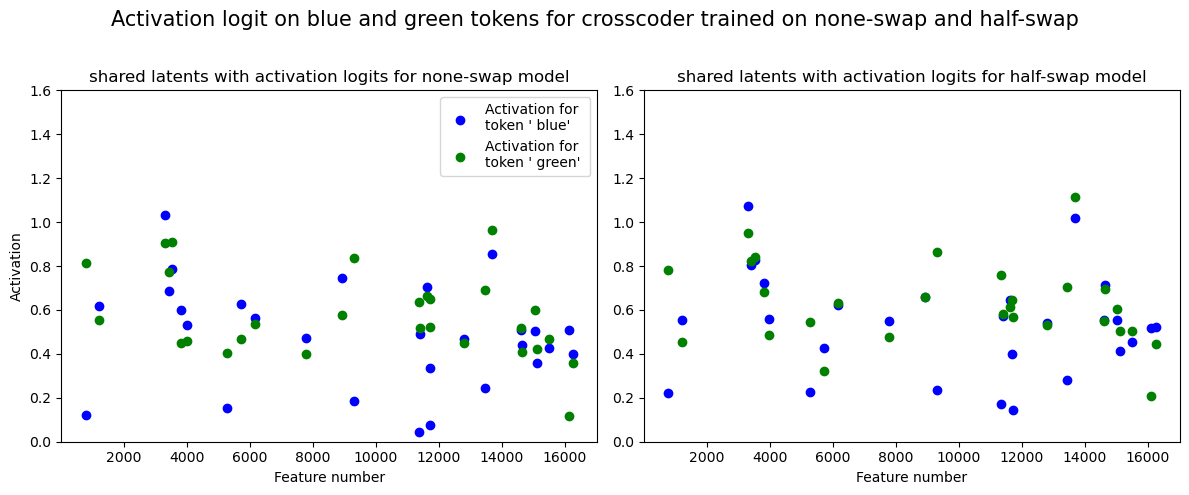

In [16]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Activation logit on blue and green tokens for crosscoder trained on none-swap and half-swap', fontsize=15)

values = np.array(list(none_half_shared.values()))
ids = list(none_half_shared.keys())
axes[0].scatter(ids, values[:, 0], c='b', label='Activation for\ntoken \' blue\' ')
axes[0].scatter(ids, values[:, 2], c='g', label='Activation for\ntoken \' green\' ')
axes[0].set_ylim(0, 1.6)
axes[0].set_title('shared latents with activation logits for none-swap model')
axes[0].set_xlabel('Feature number')
axes[0].set_ylabel('Activation')
axes[0].legend()

axes[1].scatter(ids, values[:, 1], c='b')
axes[1].scatter(ids, values[:, 3], c='g')
axes[1].set_ylim(0, 1.6)
axes[1].set_title('shared latents with activation logits for half-swap model')
axes[1].set_xlabel('Feature number')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('none_half_shared.png')
plt.show()

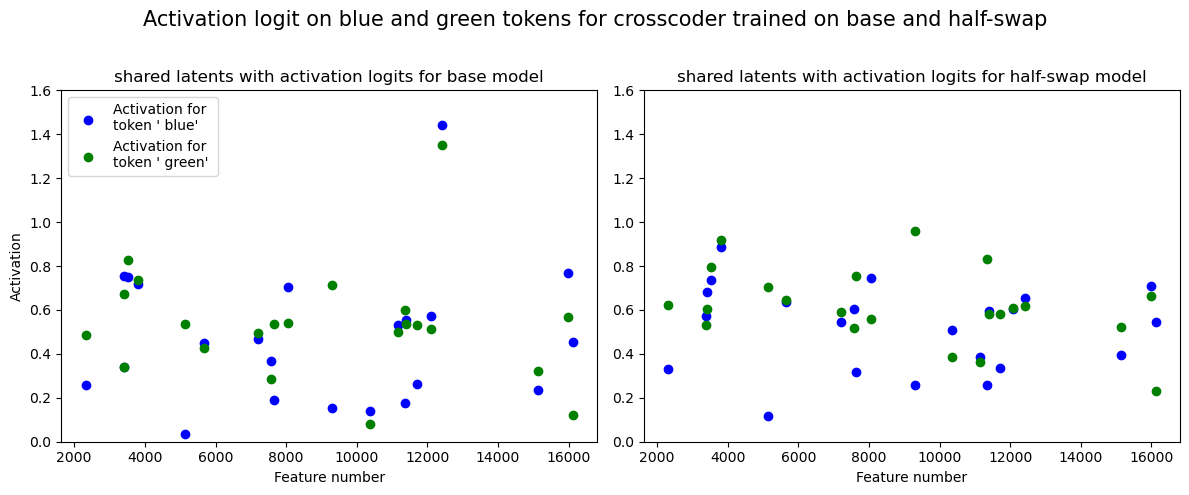

In [116]:

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Activation logit on blue and green tokens for crosscoder trained on base and half-swap', fontsize=15)

values = np.array(list(base_half_shared.values()))
ids = list(base_half_shared.keys())
axes[0].scatter(ids, values[:, 0], c='b', label='Activation for\ntoken \' blue\' ')
axes[0].scatter(ids, values[:, 2], c='g', label='Activation for\ntoken \' green\' ')
axes[0].set_ylim(0, 1.6)
axes[0].set_title('shared latents with activation logits for base model')
axes[0].set_xlabel('Feature number')
axes[0].set_ylabel('Activation')
axes[0].legend()

axes[1].scatter(ids, values[:, 1], c='b')
axes[1].scatter(ids, values[:, 3], c='g')
axes[1].set_ylim(0, 1.6)
axes[1].set_title('shared latents with activation logits for half-swap model')
axes[1].set_xlabel('Feature number')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('base_half_shared.png')
plt.show()

Text(0.5, 1.0, '')

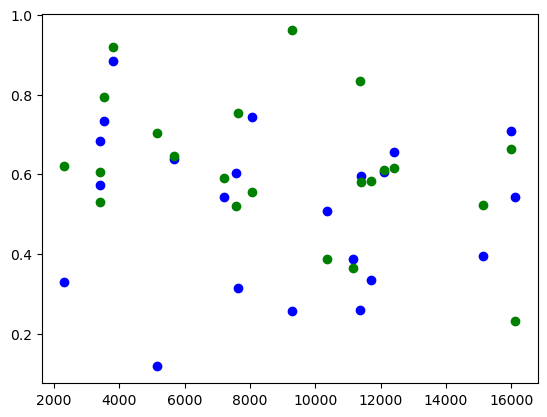

In [113]:
values = np.array(list(base_half_shared.values()))
ids = list(base_half_shared.keys())
plt.scatter(ids, values[:, 1], color='blue')
plt.scatter(ids, values[:, 3], color='green')
plt.title('')

In [76]:
base_half = torch.load('/home/user/logits_A_base_half.pt')
base_half[0]

torch.Size([1, 256000])

In [121]:
base_half = {
    67: [-2.403103280812502e-07, -0.11618226021528244, 0.00010511746950214729, -0.06039588898420334],
79: [-7.156431092880666e-05, -0.1282784342765808, -0.0006726093124598265, -0.15977363288402557],
240: [0.006309790536761284, -0.02075730264186859, 0.008582637645304203, -0.00818311795592308],
259: [0.00015757500659674406, 0.05061836168169975, 0.00035074149491265416, 0.06547510623931885],
587: [-0.0012425575405359268, -0.14040420949459076, -0.014291246421635151, -0.026925180107355118],
732: [-0.013030331581830978, 0.07073768973350525, -0.022264203056693077, 0.04734942317008972],
1055: [-0.01867271214723587, -0.38137245178222656, -0.037305913865566254, -0.4893973767757416],
1427: [0.00040801873547025025, -0.07209191471338272, 0.0003391832869965583, -0.07492448389530182],
1532: [-0.0010323880705982447, 0.022593369707465172, -0.0006741781835444272, 0.02591843158006668],
1789: [0.00021205737721174955, 0.31573349237442017, 0.00020934108761139214, 0.3936253786087036],
2094: [-0.0029830813873559237, -0.14691871404647827, -0.009226033464074135, -0.2039831280708313],
2430: [6.770024629076943e-05, -0.11787235736846924, 8.35834871395491e-05, -0.17915701866149902],
2890: [0.0008443101542070508, 0.020554615184664726, -0.00041620733099989593, -0.015598096884787083],
2928: [0.00036622461630031466, 0.00441327691078186, -0.00033208989771083, -0.010501290671527386],
3175: [4.012704448541626e-05, -0.050056617707014084, 0.0002407845895504579, -0.0212283693253994],
3214: [-0.010552090592682362, -0.026815224438905716, -0.013660000637173653, -0.09534932672977448],
3355: [-0.053709279745817184, -0.33487817645072937, -0.06514494866132736, -0.40026360750198364],
3471: [0.0027278815396130085, -0.01023302786052227, 0.00790106225758791, -0.07386396825313568],
3671: [-0.00010209291212959215, -0.011096140369772911, 0.0005646008648909628, -0.008852115832269192],
3829: [-0.03710991144180298, -0.169117733836174, -0.03475112468004227, -0.12202268838882446],
3840: [6.073850818211213e-05, 0.03830643743276596, 0.00021255065803416073, 0.028273941949009895],
3935: [0.00018712013843469322, 0.035441599786281586, 0.0003115016734227538, 0.04389398545026779],
4070: [9.243303793482482e-07, -0.04180513322353363, -0.00018681221990846097, -0.07706723362207413],
4471: [-0.003674626350402832, 0.06830879300832748, 0.0407237634062767, 0.21444261074066162],
4636: [-0.0008488211315125227, 0.02538422681391239, -0.0023191990330815315, 0.004614679142832756],
4783: [8.775688911555335e-05, -0.013084386475384235, 0.00012334318307694048, -0.012013999745249748],
4840: [0.03302844613790512, 0.22267740964889526, 0.02989228069782257, 0.212275430560112],
5016: [-0.0048142606392502785, 0.01959785632789135, -0.008217760361731052, -0.012469524517655373],
5166: [0.002623050706461072, 0.037596382200717926, 0.0002048677997663617, -0.013605676591396332],
5339: [0.0006580662447959185, 0.02586296945810318, 0.00013160303933545947, 0.004246499389410019],
5449: [0.00039868050953373313, 0.31009289622306824, 0.0006361503037624061, 0.2836686968803406],
6163: [0.11432917416095734, 1.1457931995391846, 0.09102442860603333, 1.0158607959747314],
6185: [0.0359111987054348, 0.21101610362529755, 0.02983398176729679, 0.159076988697052],
6354: [0.0009140114998444915, -0.018940802663564682, 0.002106729196384549, -0.02368880808353424],
6368: [-5.221423634793609e-06, -0.022854607552289963, -2.651560862432234e-05, -0.035879869014024734],
6402: [0.015165012329816818, 0.03255157172679901, 0.014124231413006783, 0.11032795161008835],
6435: [0.0035871220752596855, -0.004821809008717537, 0.0024526207707822323, 0.006064383313059807],
6520: [0.0020383447408676147, -0.00709256948903203, 0.00177651213016361, 0.006402462720870972],
6544: [0.0009578592726029456, 0.10023285448551178, -0.0007640685653313994, 0.08224989473819733],
6658: [-0.00187325244769454, -0.005462217144668102, -0.00022556819021701813, 0.012408746406435966],
6708: [0.0003447256749495864, 0.29630452394485474, 0.0002405069681117311, 0.35251176357269287],
6793: [0.0001687682088231668, -0.015522381290793419, 0.00012426039029378444, -0.022743504494428635],
6844: [0.010606415569782257, -0.0032349489629268646, 0.003597391303628683, -0.003629656508564949],
7015: [-0.0005192428361624479, -0.023040922358632088, -0.0002199662267230451, -0.030003124848008156],
7198: [0.006621594540774822, -0.016979750245809555, 0.00973360612988472, -0.0038841087371110916],
7610: [0.02426266483962536, 0.2727910876274109, 0.026404425501823425, 0.31019312143325806],
8012: [0.00012432964285835624, 0.13269716501235962, 0.0004906859830953181, 0.2080003023147583],
8143: [0.0225832536816597, 0.4846832752227783, 0.024659432470798492, 0.5052121877670288],
8169: [0.10476522892713547, 0.605903148651123, 0.1394675374031067, 0.8049042224884033],
8408: [0.00022195139899849892, 0.015297889709472656, 0.001610965351574123, 0.04973401874303818],
8465: [0.0001321771997027099, -0.023482052609324455, 0.000121523771667853, -0.031849537044763565],
8544: [0.0001174474018625915, 0.038406647741794586, 0.0007258681580424309, 0.07133682817220688],
8929: [0.0024899104610085487, -0.06066799536347389, 0.00481627369299531, -0.05435376986861229],
9483: [1.5574507415294647e-05, -0.045589037239551544, -0.012271573767066002, 0.06561990082263947],
9518: [-0.013110470958054066, -0.08213333040475845, -0.010229192674160004, -0.08881407976150513],
9738: [0.0006003988673910499, -0.017632462084293365, -5.701225745724514e-05, -0.02481553703546524],
9852: [0.00039651463157497346, -0.006331673823297024, -0.0003425336617510766, -0.04571482539176941],
9997: [0.0026232905220240355, 0.010052538476884365, -0.0003332925261929631, 0.03056776523590088],
10067: [0.008041329681873322, 0.03234414756298065, 0.0037112399004399776, -0.024376172572374344],
10109: [-0.00010195944923907518, -0.09567918628454208, -0.00010554076288826764, -0.091006338596344],
10126: [-0.047176212072372437, -0.07824012637138367, -0.03980257734656334, -0.005533944815397263],
10156: [0.006921036168932915, -0.09452873468399048, 0.001520172692835331, -0.11062978953123093],
10580: [-0.001545107108540833, -0.006602294743061066, -0.003588032443076372, -0.051380857825279236],
11074: [0.0007576013449579477, 0.02962278202176094, 5.553339724428952e-05, 0.009504774585366249],
11145: [0.0059571461752057076, 0.017643887549638748, -0.008393168449401855, -0.06233224272727966],
11198: [-0.045286230742931366, -0.37208861112594604, -0.06763255596160889, -0.48835816979408264],
11251: [0.000285520451143384, -0.08301596343517303, 1.16716546472162e-05, -0.02799605019390583],
11266: [0.04754164442420006, 0.08531966805458069, 0.027636295184493065, 0.12511618435382843],
11474: [1.4053319318918511e-05, -0.04337566718459129, -6.187805411173031e-05, -0.04544972628355026],
11986: [-0.012918819673359394, -0.08998067677021027, -0.005862894468009472, -0.09500466287136078],
12047: [0.0004566510906443, -0.019353926181793213, -0.0001852456189226359, -0.03656177967786789],
12119: [-0.002195879817008972, -0.04260987788438797, -0.004356171004474163, -0.03151474520564079],
12620: [0.025702135637402534, 0.05146249756217003, 0.02664225548505783, 0.04266298934817314],
12797: [0.03281606361269951, 0.09083332121372223, 0.00831049308180809, 0.09590645134449005],
12937: [0.010680671781301498, 0.11877113580703735, -0.007201880216598511, 0.056035153567790985],
13088: [-3.46401720889844e-05, -0.03535131365060806, -3.1247283914126456e-05, -0.04851822927594185],
13313: [1.470207644160837e-05, -0.03904338181018829, -0.00029598790570162237, -0.040276896208524704],
13407: [-0.0013476645108312368, -0.18742378056049347, -0.0014217576244845986, -0.21757598221302032],
13480: [-0.010977482423186302, -0.19207292795181274, -0.008762851357460022, -0.18238623440265656],
13522: [-0.0018249591812491417, -0.02146156318485737, -0.0012297527864575386, 0.01211778074502945],
13674: [0.006433937232941389, 1.7464977502822876, 0.005156575236469507, 1.62757408618927],
13798: [-0.00041146838339045644, -0.0037357136607170105, -0.0009395239176228642, 0.006670712027698755],
14090: [-0.00014703089254908264, -0.018302544951438904, 0.0004971018643118441, -0.03066125139594078],
14166: [0.007285676430910826, -0.03797343745827675, 0.029924241825938225, 0.005174428224563599],
14335: [0.000992413959465921, -0.027162551879882812, -0.00017742524505592883, -0.06562967598438263],
14482: [-0.0002958468394353986, -0.3339231610298157, -0.00015034989337436855, -0.3608170449733734],
14786: [0.00137765659019351, -0.004037883132696152, 0.0025284932926297188, -0.006447718013077974],
15052: [0.005468652583658695, 0.0035536736249923706, 0.010603759437799454, 0.03345843404531479],
15274: [0.01308642327785492, 0.007556590251624584, 0.0008359700441360474, 0.033177170902490616],
15633: [8.819845970720053e-05, -0.03892354667186737, 0.00040384294698014855, -0.02615857496857643],
15994: [-0.002168293111026287, -0.07797466963529587, -0.004170527681708336, -0.061750832945108414],
16377: [-0.03730420023202896, -0.23548156023025513, -0.017492836341261864, -0.18393805623054504],
757: [-0.00812632218003273, 0.0002605642075650394, -0.03165019303560257, 6.973804556764662e-05],
1045: [0.10063798725605011, 0.011848549358546734, 0.05012008547782898, 0.0067872339859604836],
1411: [-0.04581305384635925, -0.00022344787430483848, -0.046043284237384796, -3.123341593891382e-05],
1419: [-0.032315969467163086, -0.00016380197484977543, -0.04927960783243179, -0.00015453234664164484],
1920: [-0.024950221180915833, 0.003450392745435238, -0.0051217712461948395, 0.0005671186954714358],
1928: [-0.03522590547800064, 0.009740982204675674, -0.08168589323759079, -0.00016653072088956833],
2122: [-0.053239189088344574, -0.00023086996225174516, -0.11584384739398956, -0.0006140144541859627],
2250: [-0.07489514350891113, -0.007297370582818985, -0.10038125514984131, -0.009923170320689678],
2357: [0.050097472965717316, 0.0005075230728834867, 0.0440397784113884, 0.0004303395398892462],
2614: [-0.015653911978006363, 0.014478275552392006, -0.049692243337631226, 0.008744042366743088],
2757: [-0.14282391965389252, 0.001183027634397149, -0.1359887719154358, -0.005567807704210281],
2824: [-0.006883073598146439, 0.0003408704942557961, -0.0054674455896019936, 0.0003152251592837274],
3141: [-0.022489212453365326, 2.3102940758690238e-05, -0.041281912475824356, -0.00011565165186766535],
3401: [-0.03644900023937225, -0.00018721589003689587, -0.045071445405483246, -0.00031300968839786947],
3477: [0.030693018808960915, 0.0005242499755695462, 0.06131034716963768, 0.0006975211435928941],
3815: [-0.04578013718128204, 0.0008550685597583652, -0.02098572999238968, 0.0005575990071520209],
4523: [0.07983275502920151, 0.0006395187810994685, 0.07757396996021271, 0.00024619553005322814],
4723: [-0.049418333917856216, 0.00566649716347456, -0.04576940834522247, 0.0036091054789721966],
4917: [0.027796411886811256, 0.00038893631426617503, 0.008446838706731796, 0.0001563730329507962],
4927: [-0.06178446114063263, -1.4040302630746737e-05, -0.026936747133731842, -0.00010941755317617208],
5197: [0.019747477024793625, -0.004695911891758442, 0.018080413341522217, -0.006072193384170532],
6004: [0.04700130596756935, 0.00032701829331927, 0.03815273195505142, 0.00038634787779301405],
6157: [0.0035736076533794403, 8.015339699340984e-05, 0.004380011931061745, -6.109873356763273e-05],
6366: [-0.04287417232990265, 0.0001639903784962371, -0.06234040483832359, -0.0001739071449264884],
6558: [-0.019942056387662888, 0.007420804351568222, -0.05652864649891853, 0.010199351236224174],
6623: [-0.018551314249634743, 0.00010591868340270594, -0.038889262825250626, -4.304964022594504e-05],
6669: [0.0023406650871038437, 0.00011307584645692259, -0.014735600911080837, -2.348487396375276e-05],
6752: [-0.044460445642471313, -2.577099803602323e-05, -0.06600424647331238, -0.0003385805175639689],
6803: [-0.014895372092723846, -0.014071051962673664, -0.0917549878358841, -0.019535157829523087],
6810: [-0.03441958501935005, 9.317592775914818e-05, -0.04941380023956299, -6.949299859115854e-05],
7058: [0.035026099532842636, 0.0006229337304830551, 0.021551288664340973, 0.0006361391278915107],
7187: [-0.1081579402089119, -0.012534935027360916, -0.12214811146259308, -0.016630711033940315],
7703: [-0.01864953339099884, 0.004575498402118683, -0.0028896797448396683, 0.000666346400976181],
7837: [-0.01064380630850792, 6.439187563955784e-05, -0.0297078974545002, -0.00010947317787213251],
7885: [-0.0025252755731344223, 0.005744706839323044, -0.014890339225530624, 0.0019950903952121735],
8415: [-0.06753943860530853, -0.0009157187305390835, -0.10019320249557495, -0.0010013311402872205],
8735: [0.09679050743579865, 0.04313993453979492, -0.021554190665483475, 0.005691285245120525],
9036: [-0.016341686248779297, 0.00020342932839412242, 0.002518638037145138, 0.00021926386398263276],
9700: [-0.06330452859401703, -0.0002319954364793375, -0.09846743941307068, -0.00037590909050777555],
9879: [0.020829172804951668, 0.00040598883060738444, 0.01707298681139946, 0.0002900366089306772],
10291: [-0.04481302201747894, -0.0005213842960074544, -0.03802104294300079, -0.0003554779104888439],
10856: [-0.05302038788795471, 0.010616293177008629, -0.11239555478096008, 0.0038350929971784353],
11826: [-0.028376424685120583, 0.0028909873217344284, -0.10652445256710052, -0.00023885921109467745],
12006: [0.03927067667245865, 7.160073437262326e-05, 0.005483750253915787, -3.5060780646745116e-05],
12087: [-0.04268486052751541, -0.00023149448679760098, -0.03138463944196701, 0.00020631487132050097],
12368: [0.005005935672670603, 0.004975613206624985, 0.027338210493326187, 0.0032614876981824636],
12416: [-0.07842246443033218, 0.017847536131739616, -0.10510700196027756, 0.015738429501652718],
12663: [0.153472900390625, 0.00032682425808161497, 0.14154012501239777, 2.827167190844193e-05],
12862: [-0.05890808254480362, 0.008326511830091476, -0.07532090693712234, -0.003655719570815563],
13061: [-0.017389684915542603, -0.0002783765667118132, -0.038052212446928024, -0.0001609332684893161],
13973: [-0.17127814888954163, -0.0005954711232334375, -0.1949494481086731, -0.00060424511320889],
14855: [-0.10829763114452362, -0.005165045615285635, -0.06512279808521271, -0.00035090753226540983],
14891: [-0.05310172960162163, -0.04643003270030022, 0.013267608359456062, -0.05216598883271217],
15534: [-0.06442736089229584, 0.0088433139026165, -0.03302884101867676, 0.015358412638306618],
16105: [-0.011286294087767601, -7.855953299440444e-06, 9.591039270162582e-05, 0.0007538506761193275],
16294: [-0.1424604058265686, 0.02527649700641632, -0.07395140081644058, 0.022520802915096283]
}
none_half = {67: [1.9282788343844004e-06, -0.07370803505182266, 8.591111964051379e-07, -0.04172385483980179],
240: [0.0001326446799794212, -0.013937843963503838, -2.5090150302276015e-05, -0.013749266043305397],
860: [0.002002439461648464, 0.21358264982700348, 0.0016124265966936946, 0.1621999889612198],
2263: [0.0009018797427415848, 0.004995714407414198, 0.00023408830747939646, -0.008513796143233776],
2886: [3.842051228275523e-06, -0.003732200711965561, 4.0969939618662465e-06, -0.0450059249997139],
2928: [-4.081156475876924e-06, -0.023995419964194298, -8.225715646403842e-06, -0.04449200630187988],
3840: [1.3385529200604651e-06, 0.13895370066165924, 1.6392391444242094e-06, 0.11795453727245331],
4650: [0.00025109417038038373, -0.0035463699605315924, 0.00011034257477149367, -0.011159870773553848],
4783: [2.386037067481084e-06, -0.028656108304858208, 3.919698201571009e-07, -0.044040434062480927],
5166: [0.0007427164237014949, 0.022357601672410965, 0.0005266076768748462, -0.019575247541069984],
5339: [3.96448012907058e-06, -0.019696015864610672, -4.636157245840877e-05, -0.031792692840099335],
5449: [6.543717063323129e-06, 0.31365200877189636, 6.736313480359968e-06, 0.3730681836605072],
6307: [0.008579102344810963, -0.014121633023023605, 0.009710986167192459, -0.01074061170220375],
6435: [0.0023921423126012087, -0.01149406936019659, 0.0016547003760933876, 0.0032659685239195824],
6595: [-0.0015393949579447508, -0.013617241755127907, -0.0008268138626590371, -0.002680078148841858],
6708: [5.235387106949929e-06, 0.07213388383388519, 3.694397037179442e-06, 0.10298117250204086],
6793: [1.439398261027236e-06, -0.01655004918575287, 2.4306814339070115e-08, -0.024909228086471558],
6803: [-0.04700327664613724, -0.03846103698015213, -0.06418150663375854, -0.08826934546232224],
7039: [0.00017277750885114074, 0.005949319805949926, -3.3419200917705894e-05, 0.008668904192745686],
7708: [0.0012420034036040306, -0.006761050783097744, 8.41982546262443e-05, 0.008276890963315964],
7813: [0.011960855685174465, 0.010544706135988235, 0.00320961931720376, 0.03937676548957825],
8299: [-0.01392725482583046, -0.06729243695735931, -0.011939024552702904, -0.097846120595932],
8465: [2.2877238734508865e-06, -0.025113137438893318, 7.006688065303024e-07, -0.050357699394226074],
8929: [0.015286431647837162, -0.052589353173971176, 0.013028750196099281, -0.02851777896285057],
9061: [4.666185304813553e-06, 0.08773796260356903, 5.382907147577498e-06, 0.14116713404655457],
9738: [2.912254785769619e-06, -0.03311249241232872, -1.7169966668006964e-05, -0.05137132853269577],
9852: [1.4092340279603377e-05, -0.00988776981830597, -0.00011511407501529902, -0.03501761704683304],
9997: [0.00048076082020998, -0.0020950143225491047, 2.7433387003839016e-05, 0.012691417708992958],
10244: [0.00459944736212492, 1.7745519876480103, 0.003911726176738739, 1.6421146392822266],
10559: [-0.010593393817543983, 0.01970835030078888, -0.015860432758927345, -0.0947098582983017],
10628: [-0.00019772726227529347, -0.25177326798439026, -0.0002874102792702615, -0.2895931005477905],
11074: [6.138182016002247e-06, -0.001648780656978488, -6.558613677043468e-06, -0.021696146577596664],
11145: [0.005088818725198507, -0.03557562828063965, -0.00023657456040382385, -0.04037164896726608],
11251: [-2.737303657340817e-05, -0.08993130922317505, -2.5618370273150504e-05, -0.0719432383775711],
11474: [-2.5990782887674868e-05, -0.025875022634863853, -2.7525929908733815e-05, -0.012937981635332108],
12047: [1.6651983969495632e-07, -0.03469463437795639, -9.858427802100778e-06, -0.0400417260825634],
12476: [0.0020039570517838, -0.0009812256321310997, -0.0007910429267212749, 0.03929806500673294],
12680: [0.03059558942914009, 0.14442813396453857, 0.025713633745908737, 0.14985263347625732],
13088: [-2.2759134026273387e-06, -0.20174232125282288, -4.3438499233161565e-06, -0.23742979764938354],
13313: [3.6667115637101233e-06, 0.005889599677175283, -8.661168976686895e-06, -0.005799542646855116],
14090: [-0.0005104902666062117, -0.03245621174573898, 7.14075576979667e-05, -0.004852927755564451],
14335: [0.00019828364020213485, -0.0032893684692680836, -0.0007977787754498422, -0.021681535989046097],
14626: [0.000984742771834135, 0.07127758860588074, -0.001209661248140037, -0.0062962789088487625],
14786: [0.0002624227199703455, 0.03803389519453049, 0.00015039504796732217, 0.04041599482297897],
15633: [0.0019526866963133216, -0.011411228217184544, 0.0014698745217174292, -0.01533956453204155],
16186: [0.032616324722766876, 0.060531966388225555, 0.017207356169819832, 0.007846649736166],
164: [-0.04923252761363983, -0.0014329261612147093, -0.0494077131152153, -0.00682638306170702],
646: [-0.00480532506480813, 0.0008682928164489567, -0.02575644478201866, -0.0014301517512649298],
1411: [-0.019529391080141068, -4.987237389286747e-06, -0.02625436708331108, -7.937786676848191e-07],
1419: [0.008571434766054153, -0.006848488003015518, -0.001018725335597992, -0.009127989411354065],
1434: [0.010379500687122345, 0.008122958242893219, 0.02330261841416359, -0.0168418288230896],
1928: [-0.028963927179574966, 0.006642831023782492, -0.08849850296974182, -0.003435911610722542],
2116: [-0.011247437447309494, -0.0014585908502340317, 0.021060511469841003, -0.009288272820413113],
2250: [-0.06050895154476166, -0.02501085214316845, -0.12473392486572266, -0.03482600301504135],
2300: [0.07410596311092377, 0.005364567041397095, 0.1949205994606018, 0.05929988622665405],
2357: [-0.013158757239580154, 2.864321913875756e-06, -0.044939056038856506, 3.3666826766420854e-06],
2824: [0.05185805261135101, 4.1606026002227736e-07, 0.07899188995361328, 2.3378666469398013e-07],
3141: [-0.26321643590927124, -3.5188108995498624e-06, -0.3289702832698822, -2.1395835574367084e-06],
3401: [-0.014014161191880703, 4.304665139898134e-07, -0.03021238185465336, -1.4149450180411804e-06],
3668: [-0.07573281228542328, -0.009169535711407661, -0.08536511659622192, -0.01873566396534443],
3815: [0.2765706777572632, 2.221152499259915e-06, 0.3228549659252167, 1.5545347196166404e-06],
4007: [-0.01179727353155613, 0.0035472256131470203, -0.09764937311410904, -0.0027551373932510614],
4240: [-0.005918361712247133, 0.0018106718780472875, 0.019884727895259857, -0.00014599645510315895],
5501: [-0.09504251182079315, -0.0209026001393795, 0.006324363872408867, -0.01151090208441019],
5667: [1.850777268409729, 0.0028310799971222878, 1.7034403085708618, 0.002539629815146327],
6623: [-0.14884088933467865, 3.31990406721161e-07, -0.17883707582950592, -1.0156713869946543e-06],
6669: [-0.01663818210363388, 2.1059879600215936e-06, -0.04337375983595848, -3.0657059824079624e-07],
6752: [-0.015759598463773727, -2.0001148186565842e-06, -0.03512636572122574, -8.065707675086742e-07],
6810: [-0.07749038189649582, 1.2297560658680595e-07, -0.09740408509969711, 2.1993490406657656e-07],
7696: [-0.016370490193367004, 0.01627778820693493, -0.06175371631979942, 0.013000790029764175],
7837: [0.026980753988027573, -2.1165974430914503e-06, -0.004048965405672789, -6.7842665885109454e-06],
9334: [-0.012621279805898666, 0.0033999222796410322, 0.019365495070815086, 0.0008008194854483008],
9879: [-0.07532785087823868, -4.472874337579924e-08, -0.10146491229534149, -2.775433927126869e-07],
12006: [0.11988241970539093, 7.34338209440466e-06, 0.08751256763935089, 5.9261546994093806e-06],
12087: [-0.051379621028900146, -2.0634861357393675e-06, -0.07216127216815948, -2.2467283997684717e-06],
13061: [-0.039574094116687775, -7.457467745553004e-07, -0.04910669103264809, -4.5080867039359873e-07],
13145: [-0.025502696633338928, 0.00802613701671362, -0.05724199861288071, -0.0006318311206996441],
13407: [-0.1804298460483551, -3.490547896944918e-05, -0.21796828508377075, -4.0702092519495636e-05],
13705: [0.0038128476589918137, 0.0005276123411022127, 0.03211073577404022, -9.023729944601655e-06],
13745: [0.2985677123069763, 1.5770663594594225e-05, 0.32713133096694946, 1.372370206809137e-05],
13937: [0.20123156905174255, 0.018624477088451385, 0.17091616988182068, 0.01625785417854786],
15929: [-0.0069353580474853516, 0.00245846901088953, -0.022587057203054428, -0.014792854897677898],
16105: [-0.029370596632361412, 2.374285031692125e-06, -0.05092460289597511, 2.5865356292342767e-06]}

In [33]:
base_idx = list(none_half.keys())[46:]
tuned_idx = list(none_half.keys())[:46]

Text(0, 0.5, 'Activation')

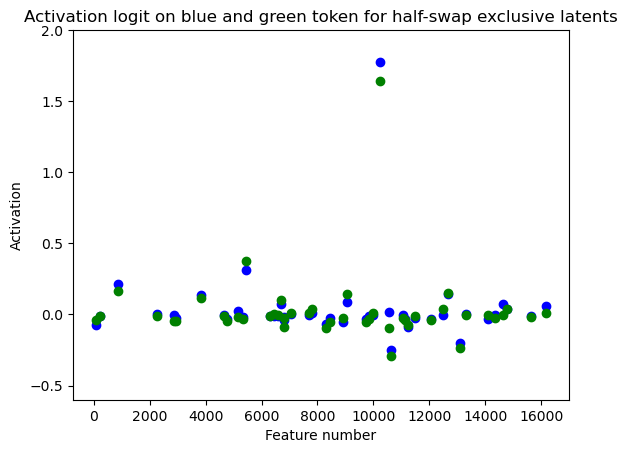

In [39]:
values = np.array(list(none_half.values()))
tuned_idx = list(none_half.keys())[:46]
plt.scatter(tuned_idx, values[:len(tuned_idx), 1], c='b')
plt.scatter(tuned_idx, values[:len(tuned_idx), 3], c='g')
plt.ylim(-.6, 2)
plt.title('Activation logit on blue and green tokens for half-swap exclusive latents')
plt.xlabel('Feature number')
plt.ylabel('Activation')

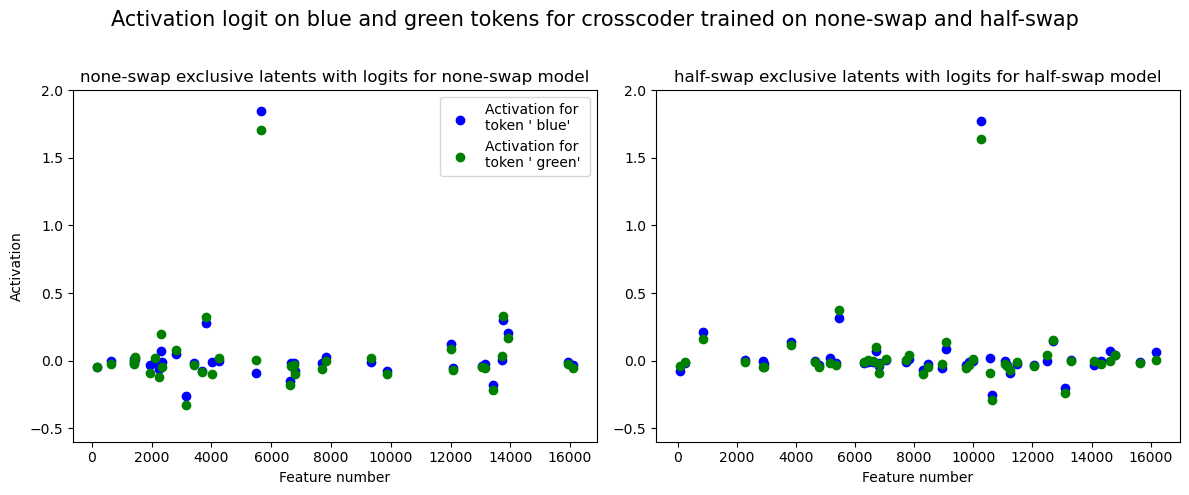

In [119]:
values = np.array(list(none_half.values()))
base_idx = list(none_half.keys())[46:]
tuned_idx = list(none_half.keys())[:46]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Activation logit on blue and green tokens for crosscoder trained on none-swap and half-swap', fontsize=15)

axes[0].scatter(base_idx, values[len(tuned_idx):, 0], c='b', label='Activation for\ntoken \' blue\' ')
axes[0].scatter(base_idx, values[len(tuned_idx):, 2], c='g', label='Activation for\ntoken \' green\' ')
axes[0].set_ylim(-.6, 2)
axes[0].set_title('none-swap exclusive latents with logits for none-swap model')
axes[0].set_xlabel('Feature number')
axes[0].set_ylabel('Activation')

axes[0].legend()
axes[1].scatter(tuned_idx, values[:len(tuned_idx), 1], c='b')
axes[1].scatter(tuned_idx, values[:len(tuned_idx), 3], c='g')
axes[1].set_ylim(-.6, 2)
axes[1].set_title('half-swap exclusive latents with logits for half-swap model')
axes[1].set_xlabel('Feature number')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('none_half.png')
plt.show()

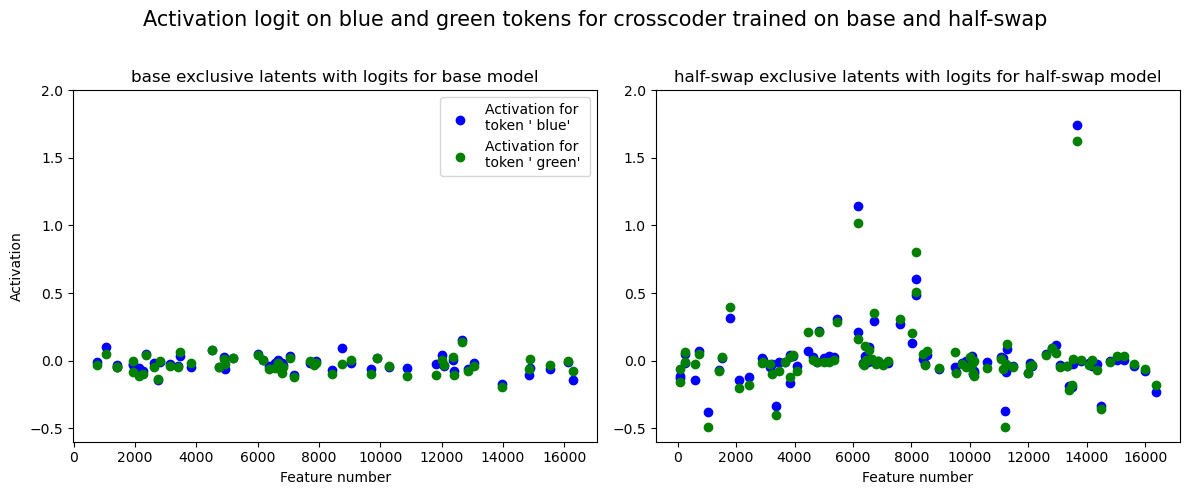

In [122]:
values = np.array(list(base_half.values()))
base_idx = list(base_half.keys())[92:]
tuned_idx = list(base_half.keys())[:92]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Activation logit on blue and green tokens for crosscoder trained on base and half-swap', fontsize=15)

axes[0].scatter(base_idx, values[len(tuned_idx):, 0], c='b', label='Activation for\ntoken \' blue\' ')
axes[0].scatter(base_idx, values[len(tuned_idx):, 2], c='g', label='Activation for\ntoken \' green\' ')
axes[0].set_ylim(-.6, 2)
axes[0].set_title('base exclusive latents with logits for base model')
axes[0].set_xlabel('Feature number')
axes[0].set_ylabel('Activation')
axes[0].legend()

axes[1].scatter(tuned_idx, values[:len(tuned_idx), 1], c='b')
axes[1].scatter(tuned_idx, values[:len(tuned_idx), 3], c='g')
axes[1].set_ylim(-.6, 2)
axes[1].set_title('half-swap exclusive latents with logits for half-swap model')
axes[1].set_xlabel('Feature number')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('base_half.png')
plt.show()

(-0.6, 2.0)

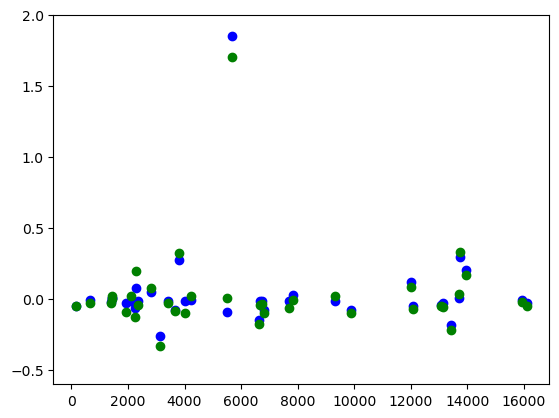

In [38]:
plt.suptitle('Activation logit on blue and green tokens')

values = np.array(list(none_half.values()))
base_idx = list(none_half.keys())[46:]
plt.scatter(base_idx, values[len(tuned_idx):, 0], c='b')
plt.scatter(base_idx, values[len(tuned_idx):, 2], c='g')
plt.ylim(-.6, 2)
plt.title('none-swap exclusive latents')
plt.xlabel('Feature number')
plt.ylabel('Activation')

values = np.array(list(none_half.values()))
tuned_idx = list(none_half.keys())[:46]
plt.scatter(tuned_idx, values[:len(tuned_idx), 1], c='b')
plt.scatter(tuned_idx, values[:len(tuned_idx), 3], c='g')
plt.ylim(-.6, 2)
plt.title('half-swap exclusive latents')
plt.xlabel('Feature number')
plt.ylabel('Activation')

(-0.6, 1.8)

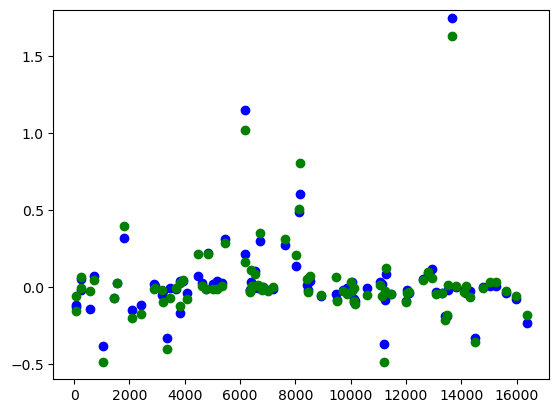

In [25]:
values = np.array(list(base_half.values()))
idx = torch.argwhere(relative_norms > .7).flatten()
plt.scatter(idx.cpu(), values[:len(idx), 1], c='b')
plt.scatter(idx.cpu(), values[:len(idx), 3], c='g')
plt.ylim(-.6, 1.8)

(-0.6, 1.8)

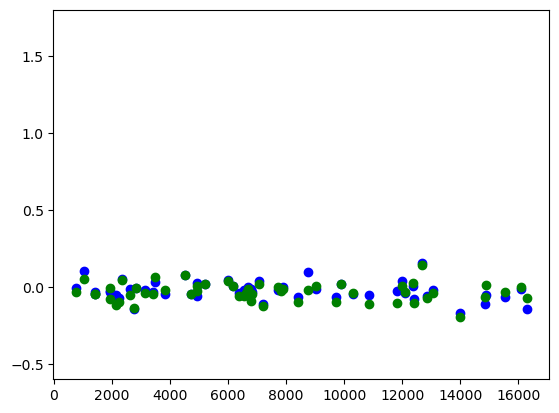

In [26]:
import numpy as np
import matplotlib.pyplot as plt
values = np.array(list(base_half.values()))
idx = torch.argwhere(relative_norms <1-.7).flatten()
plt.scatter(idx.cpu(), values[-len(idx):, 0], c='b')
plt.scatter(idx.cpu(), values[-len(idx):, 2], c='g')
plt.ylim(-.6, 1.8)

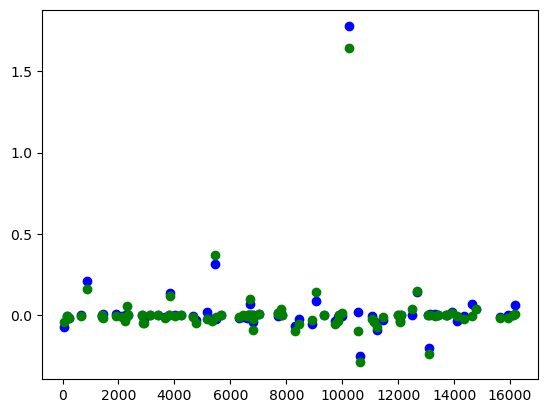

: 

In [28]:
import numpy as np
import matplotlib.pyplot as plt
values = np.array(list(data.values()))
idx = test_feature_idx
plt.scatter(idx.cpu(), values[:, 1], c='b')
plt.scatter(idx.cpu(), values[:, 3], c='g')

In [17]:
[(int(id), t) for id, t in zip(test_feature_idx, data[:, test_feature_idx].T) if any(t>0)]

[(4783, tensor([0.0000, 3.1432, 1.3787, 0.0000], device='cuda:0')),
 (5339, tensor([0.0000, 0.2242, 0.0000, 0.0000], device='cuda:0')),
 (6708, tensor([0.0000, 0.0000, 0.9635, 0.0599], device='cuda:0')),
 (6793, tensor([0.0405, 3.1822, 0.0000, 0.0000], device='cuda:0')),
 (8465, tensor([0.0000, 0.9069, 1.5562, 0.0000], device='cuda:0')),
 (9738, tensor([0.0000, 1.6381, 0.0000, 0.0000], device='cuda:0')),
 (10244, tensor([0.0000, 1.1817, 1.4607, 0.0000], device='cuda:0')),
 (11074, tensor([0.0000, 2.7688, 0.0000, 0.0000], device='cuda:0')),
 (11474, tensor([0.0000, 1.3801, 0.0000, 0.0000], device='cuda:0')),
 (12047, tensor([0.0000, 1.3130, 0.0000, 0.0000], device='cuda:0')),
 (13313, tensor([0.0000, 1.4635, 0.0000, 0.0000], device='cuda:0')),
 (1411, tensor([0.0000, 2.6089, 0.0000, 1.1044], device='cuda:0')),
 (2824, tensor([2.5160, 0.0000, 0.0000, 1.0343], device='cuda:0')),
 (3401, tensor([0.0000, 0.5948, 0.0000, 0.0000], device='cuda:0')),
 (3815, tensor([3.1578, 0.1114, 2.3529, 0.0

In [13]:
filename = "_feature_vis_demo.html"
sae_vis_data.save_feature_centric_vis(filename)

import http.server
import socketserver

PORT = 3389
Handler = http.server.SimpleHTTPRequestHandler

with socketserver.TCPServer(("0.0.0.0", PORT), Handler) as httpd:
    print(f"Serving at port {PORT}")
    httpd.serve_forever()

Saving feature-centric vis:   0%|          | 0/61 [00:00<?, ?it/s]

Serving at port 3389


24.7.121.175 - - [01/Mar/2025 04:28:30] "GET /_feature_vis_demo.html HTTP/1.1" 200 -
24.7.121.175 - - [01/Mar/2025 04:28:32] code 404, message File not found
24.7.121.175 - - [01/Mar/2025 04:28:32] "GET /favicon.ico HTTP/1.1" 404 -


KeyboardInterrupt: 

In [20]:
ids = []
for i in test_feature_idx:#range(16000):
    i = int(i)
    statement = 3868 in (sae_vis_data.feature_data_dict[i].logits_table_data_A.top_token_ids + sae_vis_data.feature_data_dict[i].logits_table_data_B.top_token_ids) \
             or 4433 in (sae_vis_data.feature_data_dict[i].logits_table_data_A.top_token_ids + sae_vis_data.feature_data_dict[i].logits_table_data_B.top_token_ids)
             #or 3868 in (sae_vis_data.feature_data_dict[i].logits_table_data_A.bottom_token_ids + sae_vis_data.feature_data_dict[i].logits_table_data_B.bottom_token_ids) \
             #or 4433 in (sae_vis_data.feature_data_dict[i].logits_table_data_A.bottom_token_ids + sae_vis_data.feature_data_dict[i].logits_table_data_B.bottom_token_ids)
    if statement:
        ids.append(i)
print(ids)

[3414, 6708, 5667]


In [16]:
import os
from IPython.display import IFrame, HTML, display

def display_html_in_notebook(filename, height=850, directory="/home/user/crosscoder-model-diff-replication"):
    """
    Display an HTML file directly in a Jupyter notebook without starting a server.
    """
    full_path = os.path.join(directory, filename)
    
    # Check if the file exists
    if not os.path.exists(full_path):
        print(f"Error: File {full_path} does not exist!")
        return
    
    # Check if file is empty
    if os.path.getsize(full_path) == 0:
        print(f"Error: File {full_path} is empty!")
        return
    
    # Method 1: Direct IFrame to the file path (works in many Jupyter environments)
    display(IFrame(src=f"files/{filename}", width="100%", height=height))
    
    # If the above doesn't work, uncomment the following alternative:
    # Method 2: Read and display the file content directly
    # with open(full_path, 'r') as f:
    #     html_content = f.read()
    # display(HTML(html_content))

# Save your visualization
filename = "_feature_vis_demo.html"
sae_vis_data.save_feature_centric_vis(filename)

# Display it in the notebook
display_html_in_notebook(filename)

Saving feature-centric vis:   0%|          | 0/3 [00:00<?, ?it/s]